# Optimising cluster shape properties with new algorithm

This algorithm uses triangles of different sizes:

1. P0113
2. P016
3. P03
4. P045

Together with the generator level information, we will use these three different sizes for three different studies and try to understand the impact of granularity on cluster properties.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import awkward as ak
import seaborn as sns
import analysis as ana
import os, time, datetime, shutil, json, pathlib
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize, MinMaxScaler, LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.datasets import make_hastie_10_2
from pandas.api.types import is_float_dtype, is_integer_dtype
from math import ceil, log2
from scipy.special import softmax
import conifer, shap
from typing import Optional, Dict, Mapping, Union
from pathlib import Path

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-pac

In [2]:
os.environ["OMP_NUM_THREADS"] = "20"
os.environ["MKL_NUM_THREADS"] = "20"

### Path to the files

In [3]:
# Photon files
photon_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgogen_filtered.h5"
photon_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_Ref_filtered.h5"
photon_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p0113_filtered.h5"
photon_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p016_filtered.h5"
photon_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p03_filtered.h5"
photon_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/photonPU200_newalgocl3d_p045_filtered.h5"

# QCD files
qcd_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogen_filtered.h5"
qcd_PU200_genpart = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgogenpart_filtered.h5"
qcd_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_Ref_filtered.h5"
qcd_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p0113_filtered.h5"
qcd_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p016_filtered.h5"
qcd_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p03_filtered.h5"
qcd_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/QCDPU200_newalgocl3d_p045_filtered.h5"

# Pion files
pion_PU200_gen = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgogen_filtered.h5"
pion_PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_Ref_filtered.h5"
pion_PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p0113_filtered.h5"
pion_PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p016_filtered.h5"
pion_PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p03_filtered.h5"
pion_PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/pionPU200_newalgocl3d_p045_filtered.h5"

# PU200 files
PU200_cl3d_Ref = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_Ref_filtered.h5"
PU200_cl3d_p0113 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p0113_filtered.h5"
PU200_cl3d_p016 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p016_filtered.h5"
PU200_cl3d_p03 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p03_filtered.h5"
PU200_cl3d_p045 = "/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_5/src/shower_shape_studies/samples/PU200_newalgocl3d_p045_filtered.h5"

In [4]:
photon_df_Ref = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_Ref)
photon_df_p0113 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p0113)
photon_df_p016 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p016)
photon_df_p03 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p03)
photon_df_p045 = ana.load_and_filter_hdf_path(photon_PU200_gen, photon_PU200_cl3d_p045)

In [5]:
count = (photon_df_p0113['genpart_gen'] != -1).sum()
print(count)

86792


In [6]:
print(photon_df_p03.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p03Tri_pt', 'cl3d_p03Tri_energy', 'cl3d_p03Tri_eta', 'cl3d_p03Tri_phi', 'cl3d_p03Tri_showerlength', 'cl3d_p03Tri_coreshowerlength', 'cl3d_p03Tri_firstlayer', 'cl3d_p03Tri_maxlayer', 'cl3d_p03Tri_varrr', 'cl3d_p03Tri_varzz', 'cl3d_p03Tri_varee', 'cl3d_p03Tri_varpp', 'cl3d_p03Tri_emaxe', 'cl3d_p03Tri_hoe', 'cl3d_p03Tri_meanz', 'cl3d_p03Tri_first1layers', 'cl3d_p03Tri_first3layers', 'cl3d_p03Tri_first5layers', 'cl3d_p03Tri_firstHcal1layers', 'cl3d_p03Tri_firstHcal3layers', 'cl3d_p03Tri_firstHcal5layers', 'cl3d_p03Tri_last1layers', 'cl3d_p03Tri_last3layers', 'cl3d_p03Tri_last5layers', 'cl3d_p03Tri_emax1layers', 'cl3d_p03Tri_emax3layers', 'cl3d_p03Tri_emax5layers', 'cl3d_p03Tri_eot', 'cl3d_p03Tri_ebm0', 'cl3d_p03Tri_ebm1', 'cl3d_p03Tri_hbm']


In [7]:
PU_df_Ref = pd.read_hdf(PU200_cl3d_Ref)
PU_df_p0113 = pd.read_hdf(PU200_cl3d_p0113)
PU_df_p016 = pd.read_hdf(PU200_cl3d_p016)
PU_df_p03 = pd.read_hdf(PU200_cl3d_p03)
PU_df_p045 = pd.read_hdf(PU200_cl3d_p045)

In [8]:
pion_df_Ref = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_Ref)
pion_df_p0113 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p0113)
pion_df_p016 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p016)
pion_df_p03 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p03)
pion_df_p045 = ana.load_and_filter_hdf_path(pion_PU200_gen, pion_PU200_cl3d_p045)

In [9]:
pion_df_p016

,event,gen_n,gen_eta,gen_phi,gen_pt,gen_energy,gen_pdgid,gen_status,genpart_exphi,genpart_exeta,...,cl3d_p016Tri_last1layers,cl3d_p016Tri_last3layers,cl3d_p016Tri_last5layers,cl3d_p016Tri_emax1layers,cl3d_p016Tri_emax3layers,cl3d_p016Tri_emax5layers,cl3d_p016Tri_eot,cl3d_p016Tri_ebm0,cl3d_p016Tri_ebm1,cl3d_p016Tri_hbm
0,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,-1.275067,-1.769644,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
1,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,-1.275067,-1.769644,...,0.000000,0.000000,0.000000,0.002587,0.005775,0.008434,0.566726,4095,15,4192256
2,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,1.848477,1.795015,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
3,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,1.848477,1.795015,...,0.000000,0.000000,0.000000,0.002587,0.005775,0.008434,0.566726,4095,15,4192256
4,14003,2,-1.782222,-1.284212,69.356628,211.930069,-211,1,0.272946,0.201797,...,0.000000,0.000000,0.000000,0.073599,0.214842,0.353606,0.509359,8191,4080,4193280
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1447209,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,2.970383,0.927353,...,0.000994,0.002979,0.016061,0.002123,0.005513,0.006811,0.028187,7149,8,4194303
1447210,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,1.425296,-0.338723,...,0.000460,0.003185,0.018773,0.057085,0.189659,0.357477,0.744865,8191,4095,4194303
1447211,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,1.425296,-0.338723,...,0.000994,0.002979,0.016061,0.002123,0.005513,0.006811,0.028187,7149,8,4194303
1447212,8987,2,-2.778728,-1.413706,144.859299,1170.510132,211,1,-2.427279,0.789054,...,0.000460,0.003185,0.018773,0.057085,0.189659,0.357477,0.744865,8191,4095,4194303


In [10]:
print(pion_df_p016.columns.tolist())

['event', 'gen_n', 'gen_eta', 'gen_phi', 'gen_pt', 'gen_energy', 'gen_pdgid', 'gen_status', 'genpart_exphi', 'genpart_exeta', 'genpart_gen', 'genpart_reachedEE', 'cl3d_p016Tri_pt', 'cl3d_p016Tri_energy', 'cl3d_p016Tri_eta', 'cl3d_p016Tri_phi', 'cl3d_p016Tri_showerlength', 'cl3d_p016Tri_coreshowerlength', 'cl3d_p016Tri_firstlayer', 'cl3d_p016Tri_maxlayer', 'cl3d_p016Tri_varrr', 'cl3d_p016Tri_varzz', 'cl3d_p016Tri_varee', 'cl3d_p016Tri_varpp', 'cl3d_p016Tri_emaxe', 'cl3d_p016Tri_hoe', 'cl3d_p016Tri_meanz', 'cl3d_p016Tri_first1layers', 'cl3d_p016Tri_first3layers', 'cl3d_p016Tri_first5layers', 'cl3d_p016Tri_firstHcal1layers', 'cl3d_p016Tri_firstHcal3layers', 'cl3d_p016Tri_firstHcal5layers', 'cl3d_p016Tri_last1layers', 'cl3d_p016Tri_last3layers', 'cl3d_p016Tri_last5layers', 'cl3d_p016Tri_emax1layers', 'cl3d_p016Tri_emax3layers', 'cl3d_p016Tri_emax5layers', 'cl3d_p016Tri_eot', 'cl3d_p016Tri_ebm0', 'cl3d_p016Tri_ebm1', 'cl3d_p016Tri_hbm']


In [11]:
qcd_df_Ref = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_Ref)
qcd_df_p0113 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p0113)
qcd_df_p016 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p016)
qcd_df_p03 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p03)
qcd_df_p045 = ana.load_and_filter_hdf_path(qcd_PU200_gen, qcd_PU200_cl3d_p045)

### Until this point, it is evident that with coarser granularity, the number of clusters increase!

In [12]:
# Delta r filter
qcd_df_Ref_filtered = ana.filter_by_delta_r(qcd_df_Ref, "cl3d_Ref", 0.5)
qcd_df_p0113_filtered = ana.filter_by_delta_r(qcd_df_p0113, "cl3d_p0113Tri", 0.5)
qcd_df_p016_filtered = ana.filter_by_delta_r(qcd_df_p016, "cl3d_p016Tri", 0.5)
qcd_df_p03_filtered = ana.filter_by_delta_r(qcd_df_p03, "cl3d_p03Tri", 0.5)
qcd_df_p045_filtered = ana.filter_by_delta_r(qcd_df_p045, "cl3d_p045Tri", 0.5)

In [13]:
# Delta r filter
pion_df_Ref_filtered = ana.filter_by_delta_r(pion_df_Ref, "cl3d_Ref", 0.1)
pion_df_p0113_filtered = ana.filter_by_delta_r(pion_df_p0113, "cl3d_p0113Tri", 0.1)
pion_df_p016_filtered = ana.filter_by_delta_r(pion_df_p016, "cl3d_p016Tri", 0.1)
pion_df_p03_filtered = ana.filter_by_delta_r(pion_df_p03, "cl3d_p03Tri", 0.1)
pion_df_p045_filtered = ana.filter_by_delta_r(pion_df_p045, "cl3d_p045Tri", 0.1)

In [14]:
photon_df_Ref_filtered = ana.filter_by_delta_r(photon_df_Ref, "cl3d_Ref", 0.05)
photon_df_p0113_filtered = ana.filter_by_delta_r(photon_df_p0113, "cl3d_p0113Tri", 0.05)
photon_df_p016_filtered = ana.filter_by_delta_r(photon_df_p016, "cl3d_p016Tri", 0.05)
photon_df_p03_filtered = ana.filter_by_delta_r(photon_df_p03, "cl3d_p03Tri", 0.05)
photon_df_p045_filtered = ana.filter_by_delta_r(photon_df_p045, "cl3d_p045Tri", 0.05)

## Let's begin the multi-class BDT

In [15]:
'''# Ref
photon_df_Ref_filtered['label'] = 0
pion_df_Ref_filtered['label'] = 3
qcd_df_Ref_filtered['label'] = 2
PU_df_Ref['label'] = 1'''

# p016
photon_df_p016_filtered['label'] = 0
pion_df_p016_filtered['label'] = 3
qcd_df_p016_filtered['label'] = 2
PU_df_p016['label'] = 1

'''# p03
photon_df_p03_filtered['label'] = 0
pion_df_p03_filtered['label'] = 3
qcd_df_p03_filtered['label'] = 2
PU_df_p03['label'] = 1'''

'''# p045
photon_df_p045_filtered['label'] = 0
pion_df_p045_filtered['label'] = 3
qcd_df_p045_filtered['label'] = 2
PU_df_p045['label'] = 1'''

"# p045\nphoton_df_p045_filtered['label'] = 0\npion_df_p045_filtered['label'] = 3\nqcd_df_p045_filtered['label'] = 2\nPU_df_p045['label'] = 1"

In [16]:
all_dfs = [qcd_df_p016_filtered, photon_df_p016_filtered, PU_df_p016, pion_df_p016_filtered]
for i in range(len(all_dfs)):
    all_dfs[i] = all_dfs[i][ana.columns_for_training('p016Tri') + ['label']]

In [17]:
df_combined = pd.concat(all_dfs, ignore_index=True)

In [18]:
X = df_combined[ana.columns_for_training('p016Tri')]
y = df_combined['label']
sample_weights = compute_sample_weight(class_weight='balanced', y=y)


In [19]:
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)

In [20]:
model = xgb.XGBClassifier(
    objective='auc',
    num_class=4,
    max_depth=5,
    n_estimators=45,
    learning_rate=0.001,
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_jobs=8,
    verbosity=1
)

/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-xgboost/1.7.5-c8f02a5fced1776967b56c88b775b4a0/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [46]:
model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.001, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=45, n_jobs=8, num_class=4,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [47]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2]), y_pred_proba, multi_class='ovr')

print(f"\n✅ Accuracy: {acc:.3f}")
print("🔢 Confusion Matrix:\n", conf_mat)
print(f"📈 ROC AUC (OvR): {roc_auc:.3f}")

IndexError: index 3 is out of bounds for axis 1 with size 3

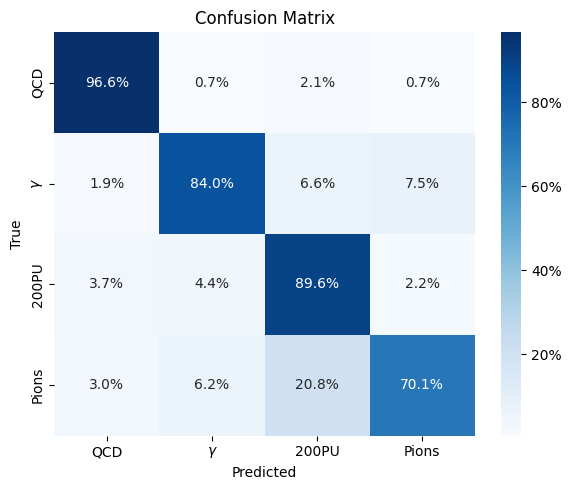

In [48]:
# Row-normalize to percentages
class_names = ['QCD', r'$\gamma$', '200PU', 'Pions']
conf_mat = np.asarray(conf_mat, dtype=float)
row_sums = conf_mat.sum(axis=1, keepdims=True)
conf_mat_pct = np.divide(conf_mat, row_sums, out=np.zeros_like(conf_mat), where=row_sums!=0) * 100.0

# Make pretty percent labels
annot_labels = np.array([[f"{v:.1f}%" for v in row] for row in conf_mat_pct])

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat_pct, annot=annot_labels, fmt="", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={"format": '%.0f%%'})
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix_percent.png", dpi=300)
plt.show()

In [49]:
y_pred_proba = model.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)

# Normalise by true class totals (row-wise)
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis] * 100

roc_auc = roc_auc_score(
    label_binarize(y_test, classes=[0, 1, 2, 3]),
    y_pred_proba,
    multi_class='ovr'
)

print(f"\n✅ Accuracy: {acc*100:.2f}%")
print("🔢 Normalised Confusion Matrix (%):\n", np.round(conf_mat_norm, 2))
print(f"📈 ROC AUC (OvR): {roc_auc*100:.2f}%")


✅ Accuracy: 88.78%
🔢 Normalised Confusion Matrix (%):
 [[96.56  0.7   2.06  0.68]
 [ 1.92 84.02  6.59  7.46]
 [ 3.7   4.43 89.63  2.24]
 [ 2.96  6.18 20.78 70.09]]
📈 ROC AUC (OvR): 96.32%


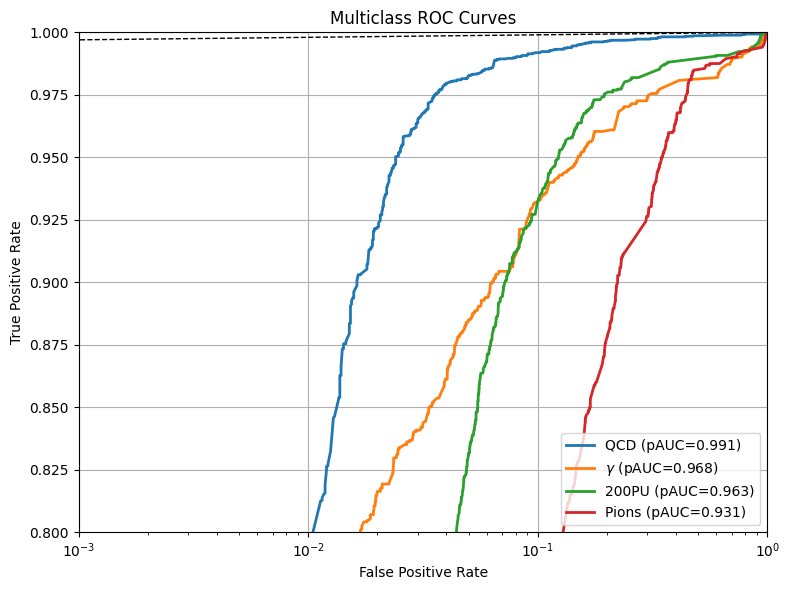

In [50]:
thr = 0.8  # signal efficiency threshold
n_classes = 4
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

fpr = {}
tpr = {}
roc_auc = {}
partial_auc = {}

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    # ROC
    fpr_full, tpr_full, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr_full, tpr_full)

    # Keep only points with TPR >= 0.8
    mask = tpr_full >= 0
    if np.sum(mask) > 1:
        fpr[i], tpr[i] = fpr_full[mask], tpr_full[mask]
        partial_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], lw=2,
                 label=f"{class_names[i]} (pAUC={partial_auc[i]:.3f})")
    else:
        fpr[i], tpr[i] = None, None
        partial_auc[i] = np.nan

# Diagonal line (optional)
plt.plot([0, 1], [0, 1], 'k--', lw=1)

plt.xlim([0.001, 1.0])
plt.ylim([thr, 1.0])  # zoom into TPR >= 0.8
plt.xscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("multiclass_roc_partial.png", dpi=300)
plt.show()

In [51]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

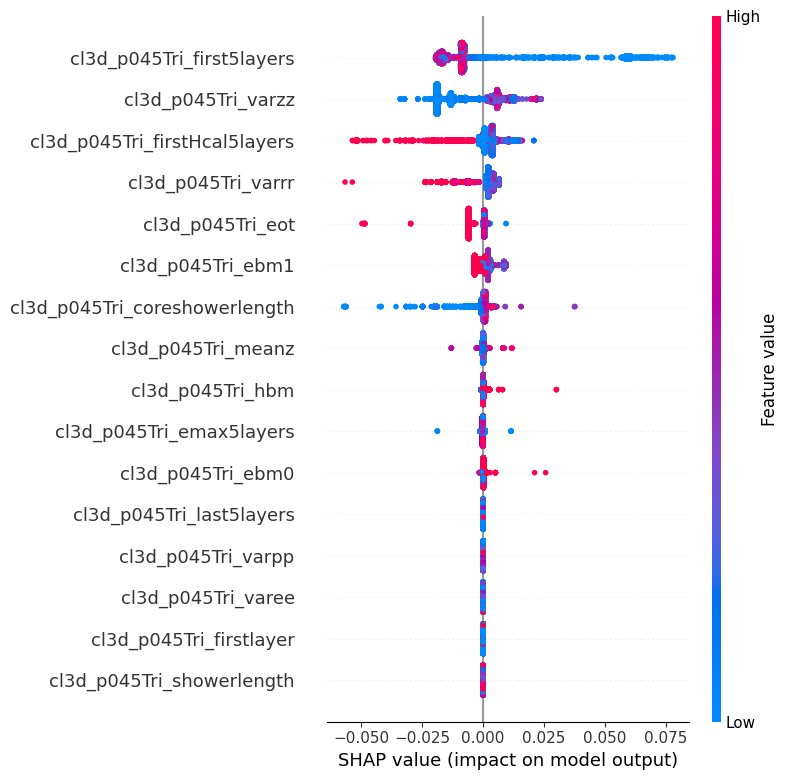

In [55]:
shap_vals_pion = shap_values[:, :, 3]
shap.summary_plot(shap_vals_pion, X_test, feature_names=ana.columns_for_training('p045Tri'), show=True)

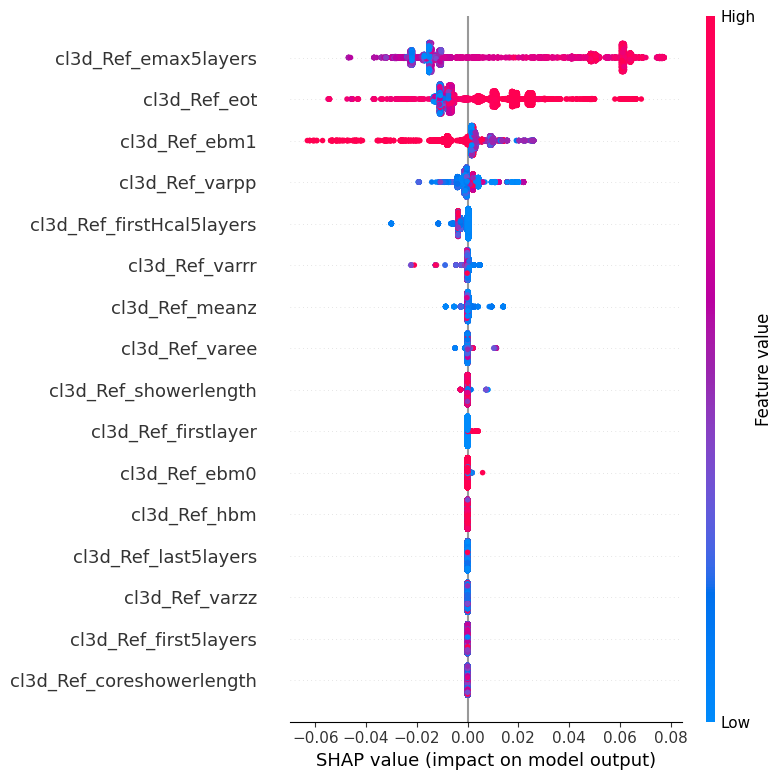

In [56]:
shap_vals_egamma = shap_values[:, :, 0]
shap.summary_plot(shap_vals_egamma, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

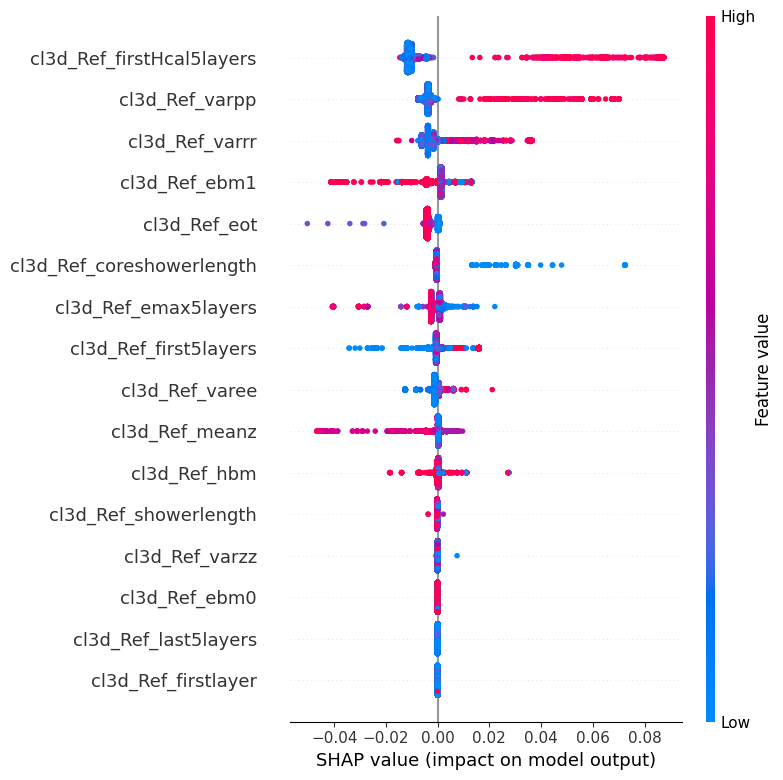

In [57]:
shap_vals_pu = shap_values[:, :, 1]
shap.summary_plot(shap_vals_pu, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

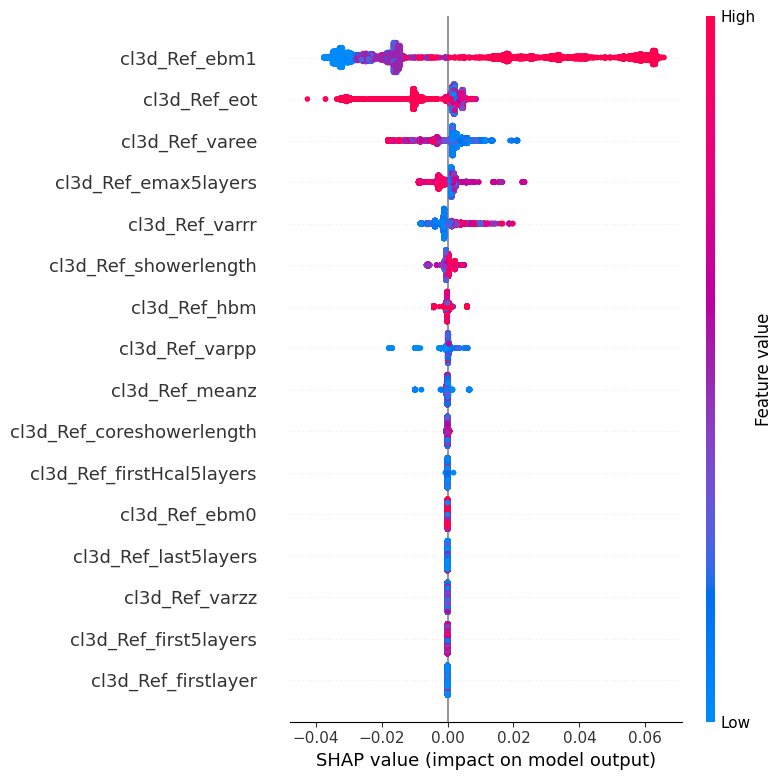

In [58]:
shap_vals_qcd = shap_values[:, :, 2]
shap.summary_plot(shap_vals_qcd, X_test, feature_names=ana.columns_for_training('Ref'), show=True)

## Understanding the difference of triangle sizes

## Let's make some plots!

Saved: plot_triangles_genmatched/pt_across_triangles.png


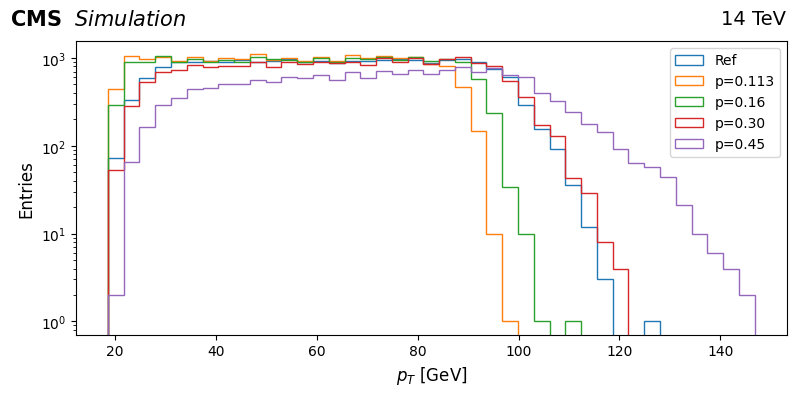

Saved: plot_triangles_genmatched/energy_across_triangles.png


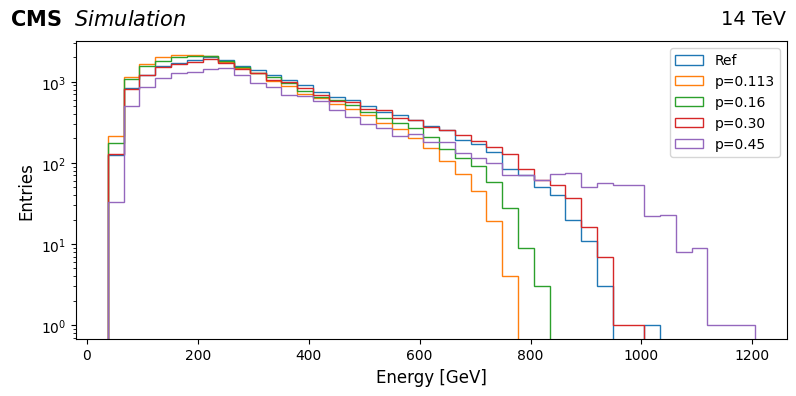

Saved: plot_triangles_genmatched/eta_across_triangles.png


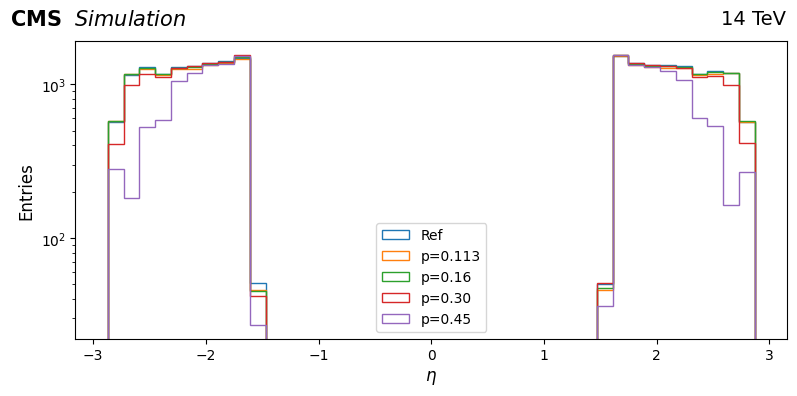

Saved: plot_triangles_genmatched/phi_across_triangles.png


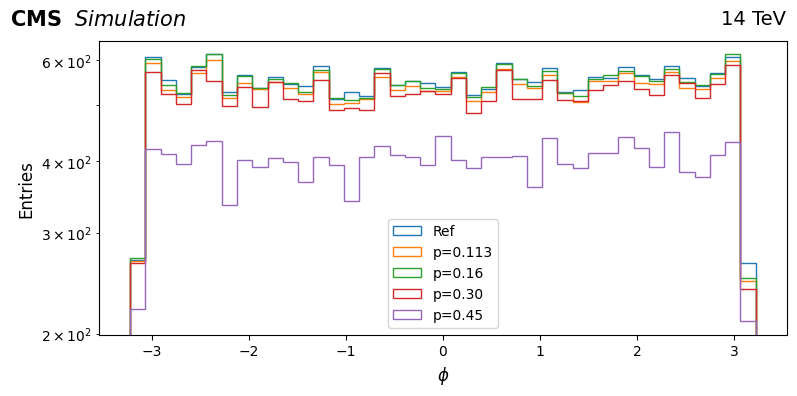

Saved: plot_triangles_genmatched/emax1layers_across_triangles.png


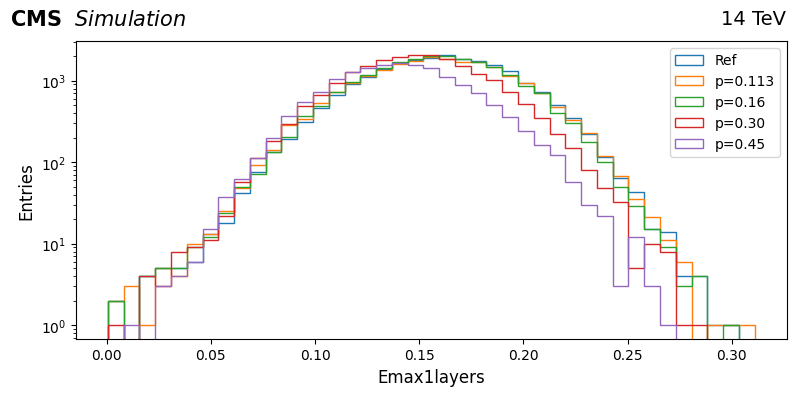

Saved: plot_triangles_genmatched/emax3layers_across_triangles.png


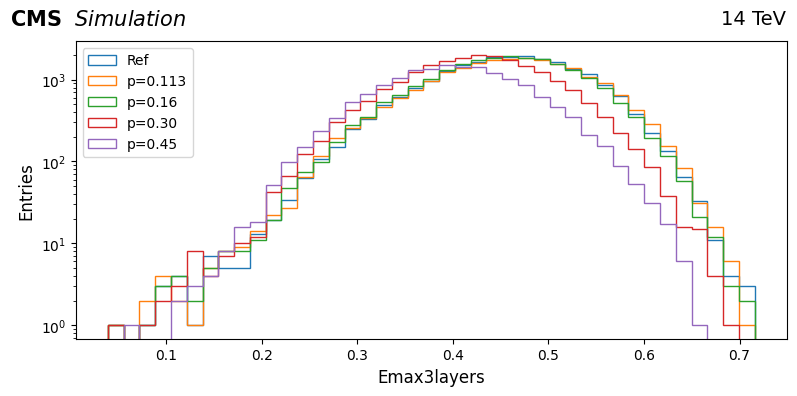

Saved: plot_triangles_genmatched/showerlength_across_triangles.png


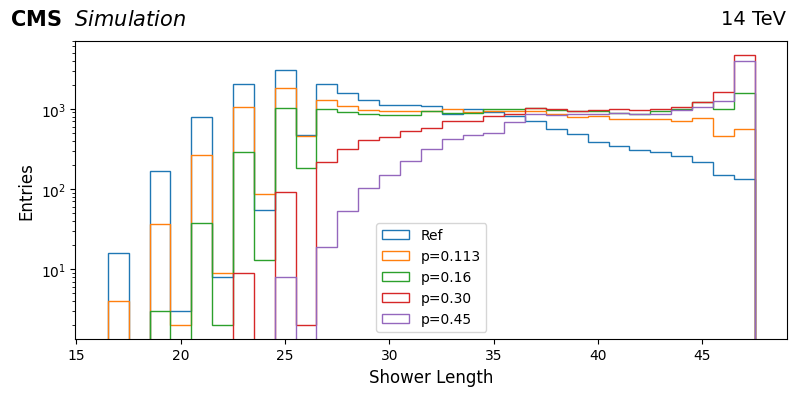

Saved: plot_triangles_genmatched/coreshowerlength_across_triangles.png


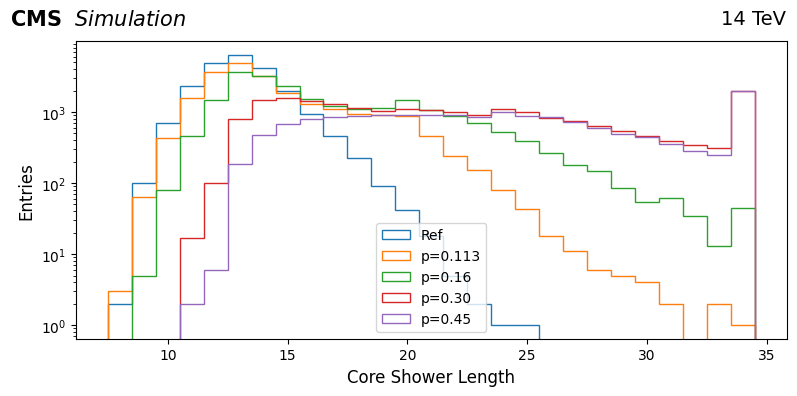

Saved: plot_triangles_genmatched/firstlayer_across_triangles.png


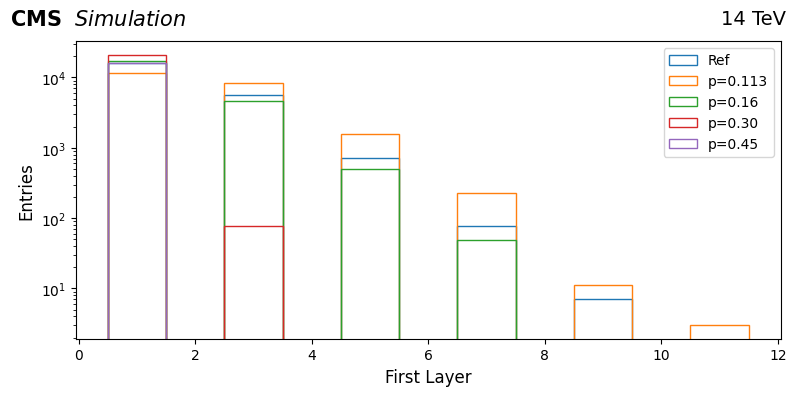

Saved: plot_triangles_genmatched/maxlayer_across_triangles.png


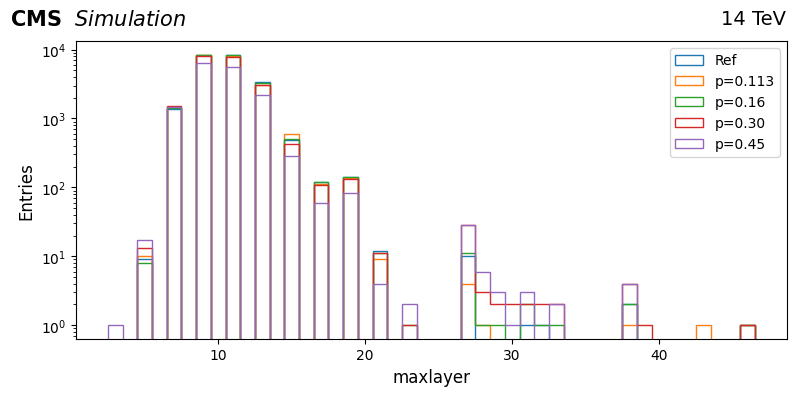

Saved: plot_triangles_genmatched/varrr_across_triangles.png


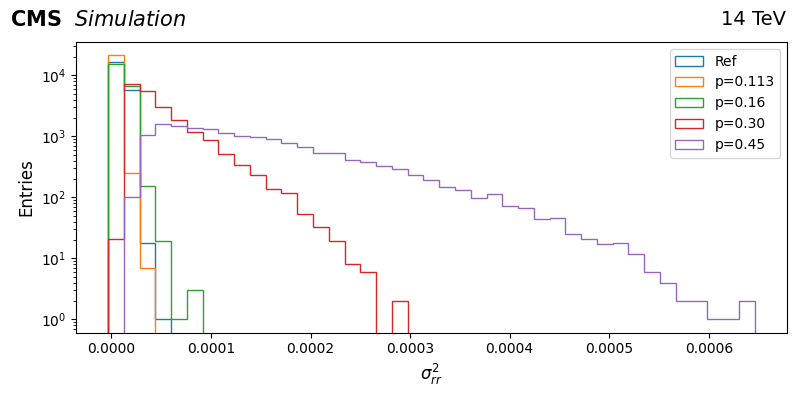

Saved: plot_triangles_genmatched/varzz_across_triangles.png


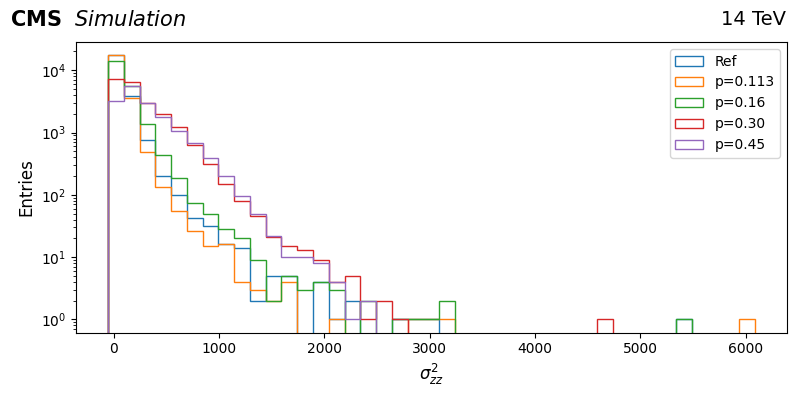

Saved: plot_triangles_genmatched/varee_across_triangles.png


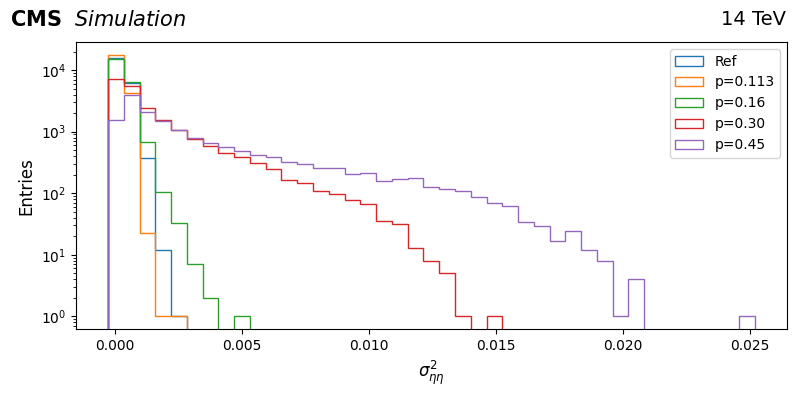

Saved: plot_triangles_genmatched/varpp_across_triangles.png


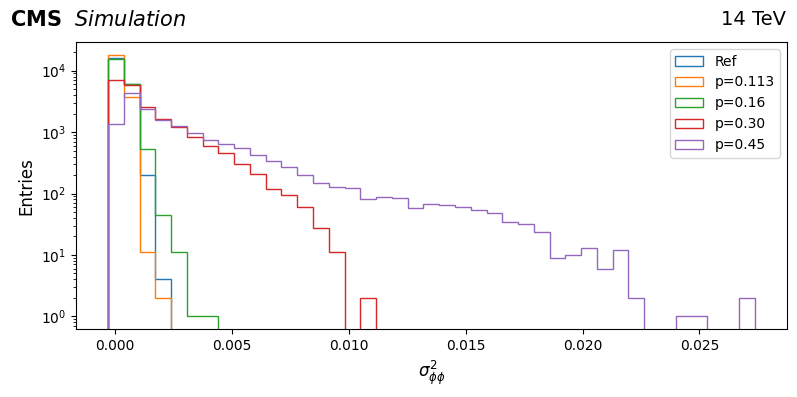

Saved: plot_triangles_genmatched/emaxe_across_triangles.png


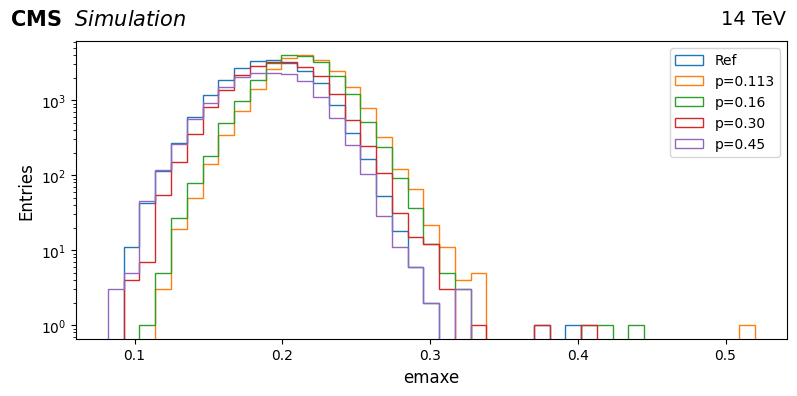

Saved: plot_triangles_genmatched/hoe_across_triangles.png


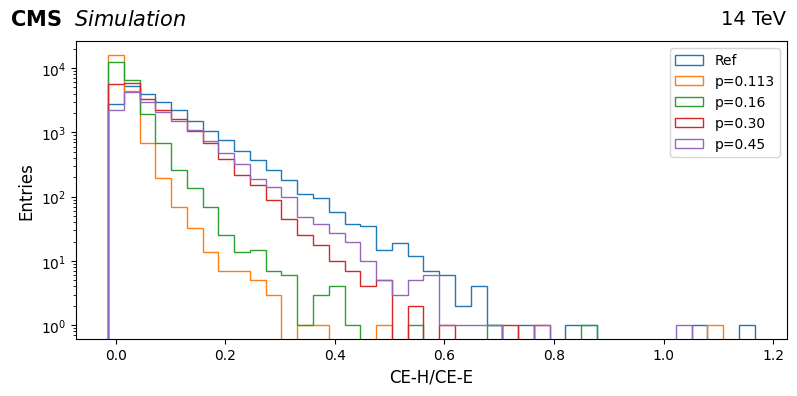

Saved: plot_triangles_genmatched/meanz_across_triangles.png


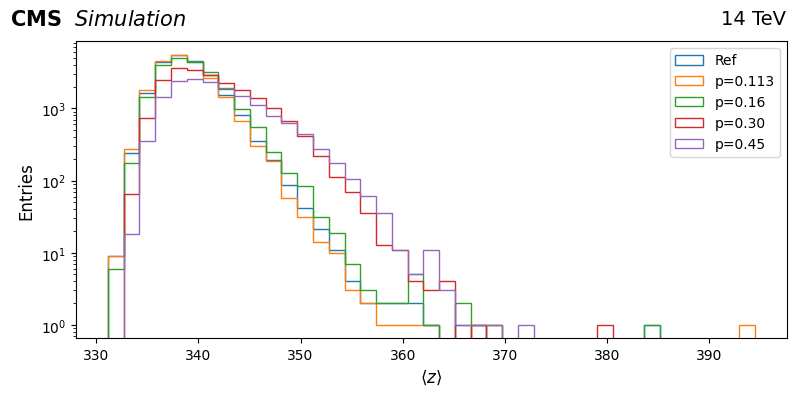

Saved: plot_triangles_genmatched/first1layers_across_triangles.png


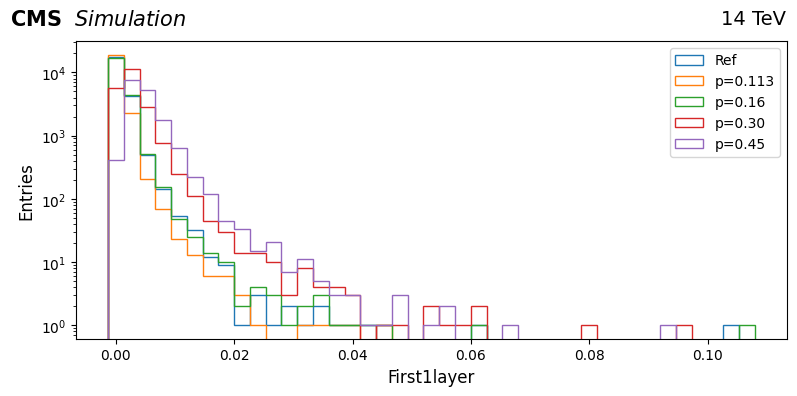

Saved: plot_triangles_genmatched/first3layers_across_triangles.png


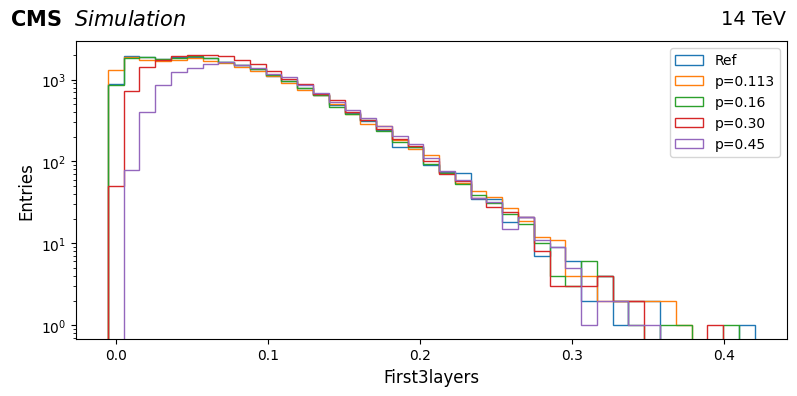

Saved: plot_triangles_genmatched/first5layers_across_triangles.png


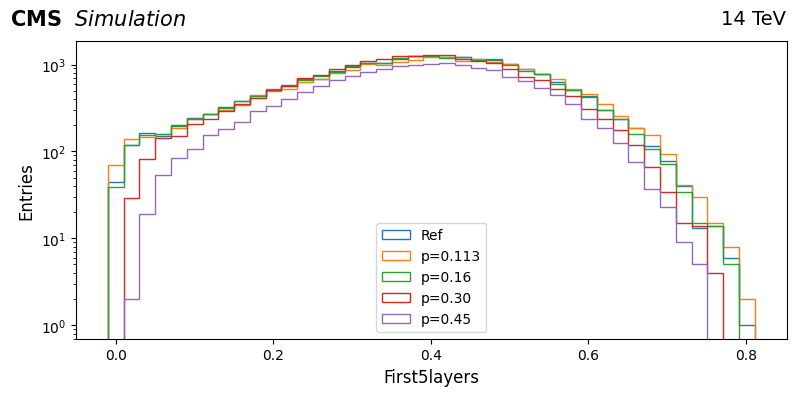

Saved: plot_triangles_genmatched/firstHcal1layers_across_triangles.png


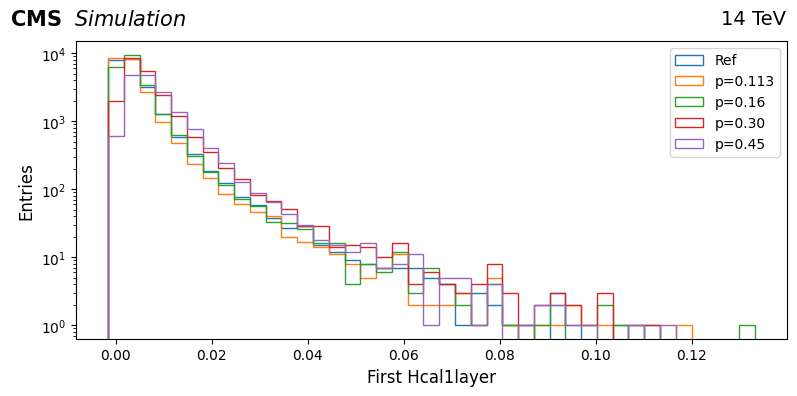

Saved: plot_triangles_genmatched/firstHcal3layers_across_triangles.png


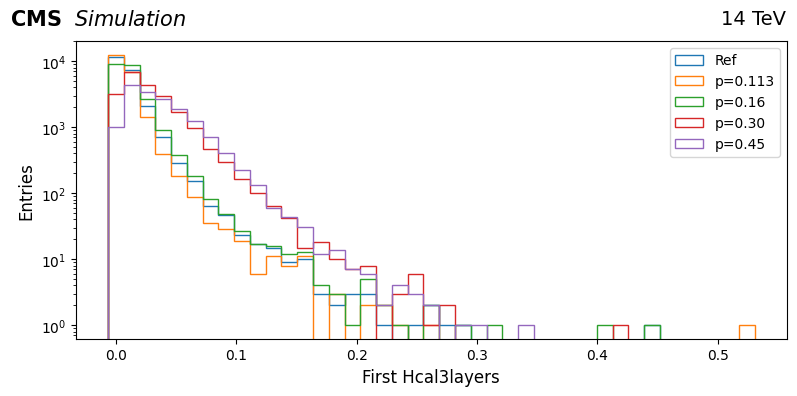

Saved: plot_triangles_genmatched/firstHcal5layers_across_triangles.png


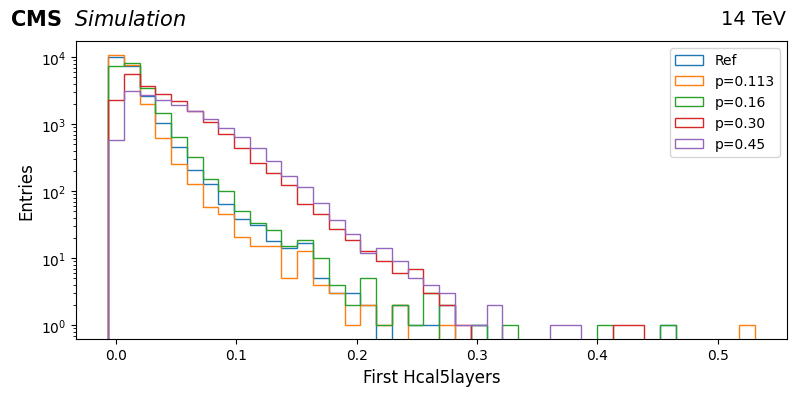

Saved: plot_triangles_genmatched/last1layers_across_triangles.png


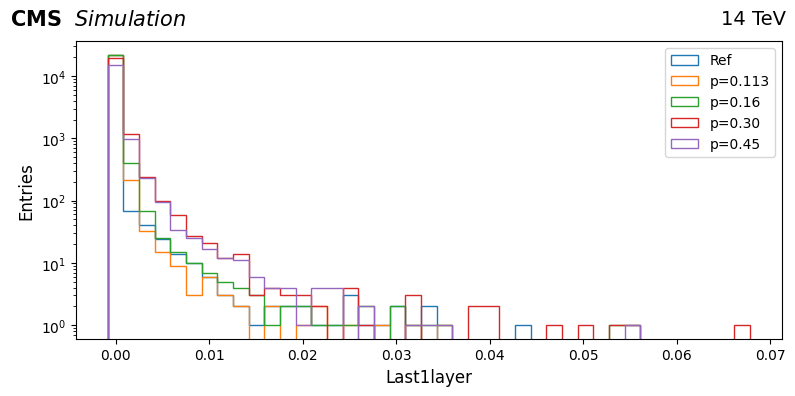

Saved: plot_triangles_genmatched/last3layers_across_triangles.png


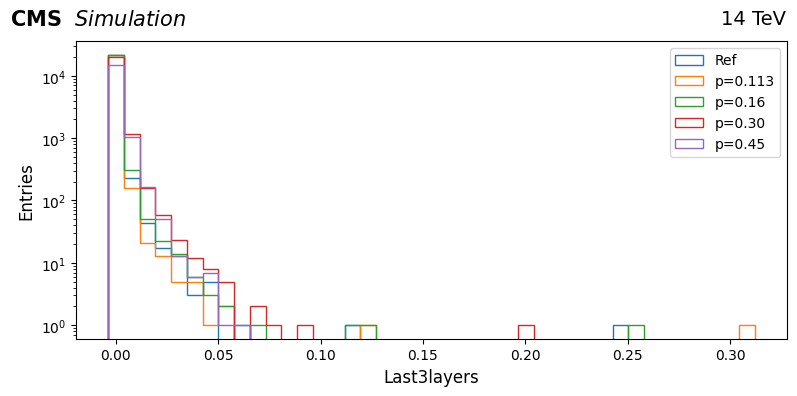

Saved: plot_triangles_genmatched/last5layers_across_triangles.png


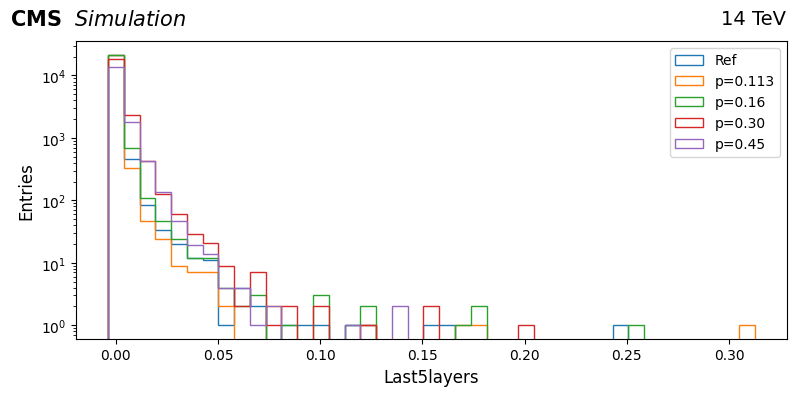

Saved: plot_triangles_genmatched/eot_across_triangles.png


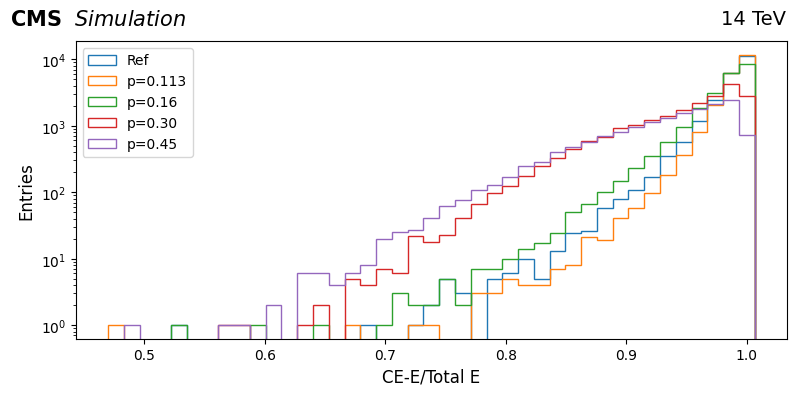

Saved: plot_triangles_genmatched/ebm0_across_triangles.png


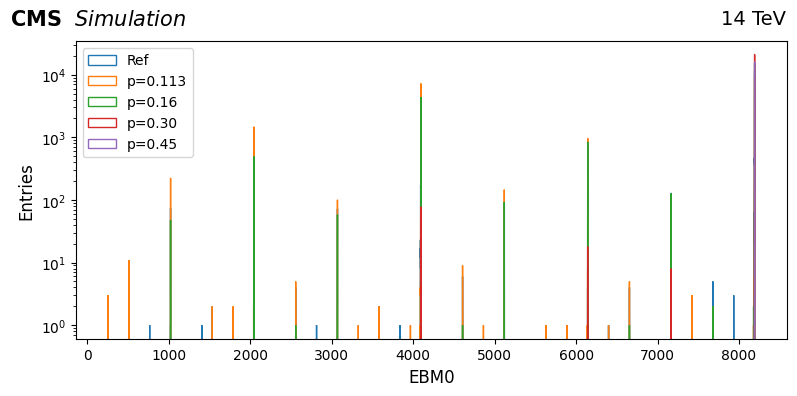

Saved: plot_triangles_genmatched/ebm1_across_triangles.png


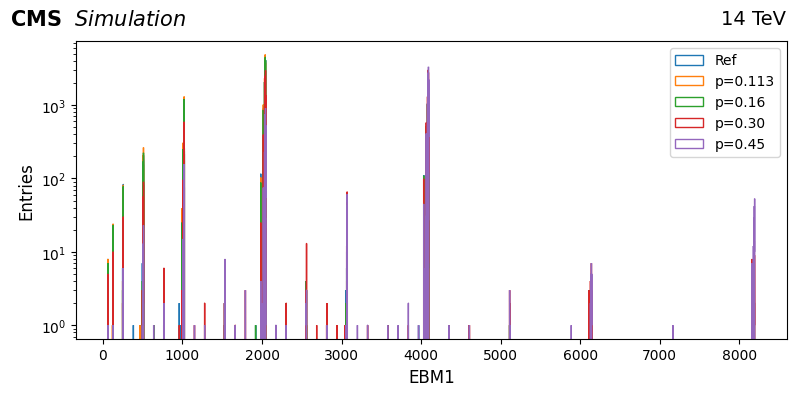

In [22]:
ana.plot_across_five_lists(
    photon_df_Ref_filtered, photon_df_p0113_filtered, photon_df_p016_filtered, photon_df_p03_filtered, photon_df_p045_filtered,
    ana.variables_to_plot('Ref'), ana.variables_to_plot('p0113Tri'), ana.variables_to_plot('p016Tri'), ana.variables_to_plot('p03Tri'), ana.variables_to_plot('p045Tri'),   # full column names per DF
    label_ref="Ref", label_p0113="p=0.113", label_p016="p=0.16", label_p03="p=0.30", label_p045="p=0.45",
    plots_dir="plot_triangles_genmatched",
    var_latex_map=None,                         # can map full name or suffix
    num_bins=40, cl3d_pt_range=(20, 200),
    pt_col_ref="cl3d_Ref_pt", pt_col_p0113="cl3d_p0113Tri_pt", pt_col_p016="cl3d_p016Tri_pt",
    pt_col_p03="cl3d_p03Tri_pt", pt_col_p045="cl3d_p045Tri_pt",
    density=False, logy=False, weight_cols=None  # weight_cols: dict with keys "ref","p016","p03","p045"
)

Saved: newsamples_Ref_plots/cl3d_Ref_pt_histogram.png


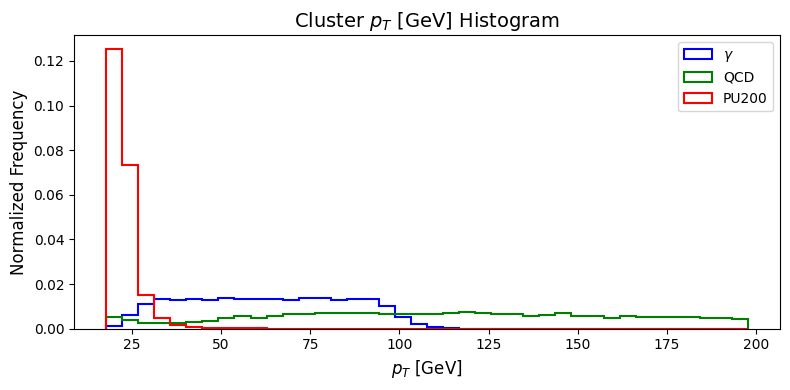

Saved: newsamples_Ref_plots/cl3d_Ref_energy_histogram.png


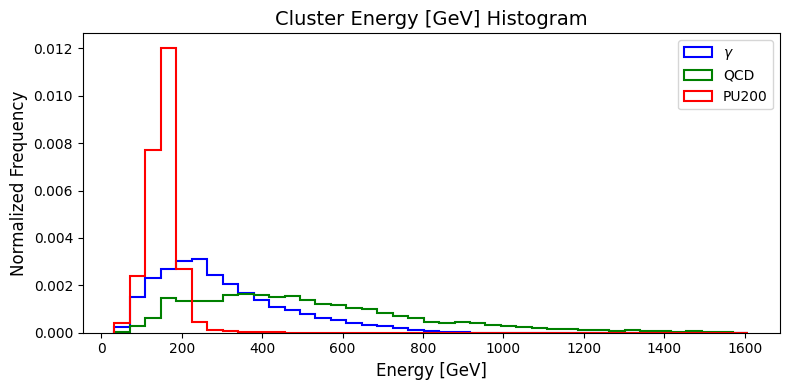

Saved: newsamples_Ref_plots/cl3d_Ref_eta_histogram.png


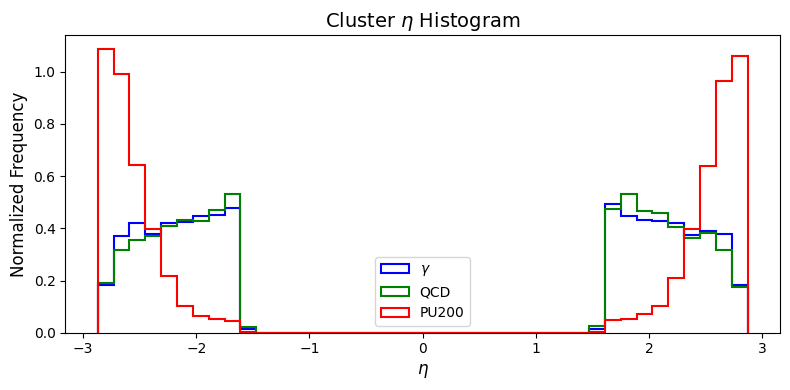

Saved: newsamples_Ref_plots/cl3d_Ref_phi_histogram.png


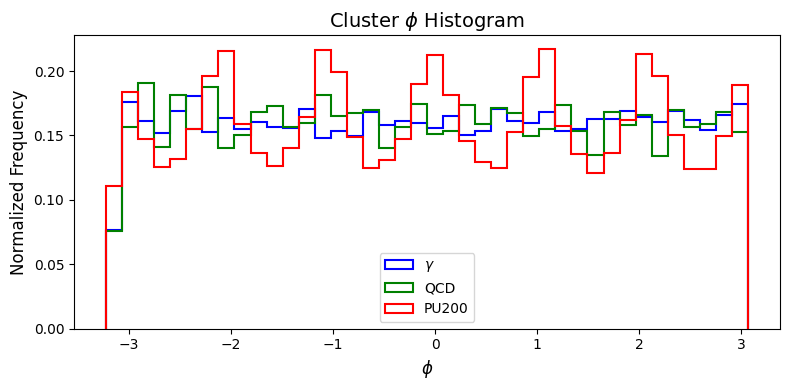

Saved: newsamples_Ref_plots/cl3d_Ref_emax1layers_histogram.png


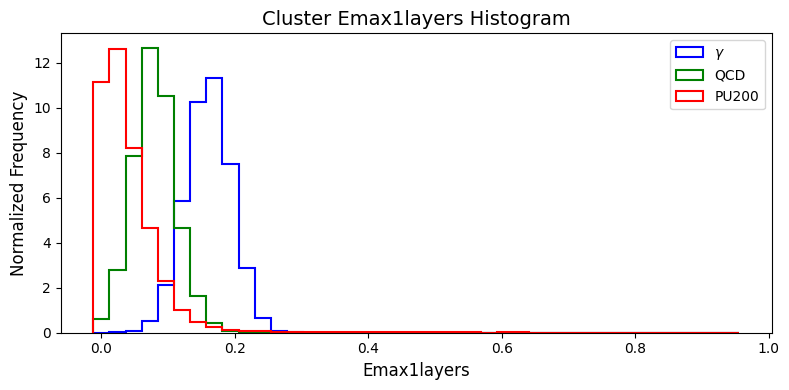

Saved: newsamples_Ref_plots/cl3d_Ref_emax3layers_histogram.png


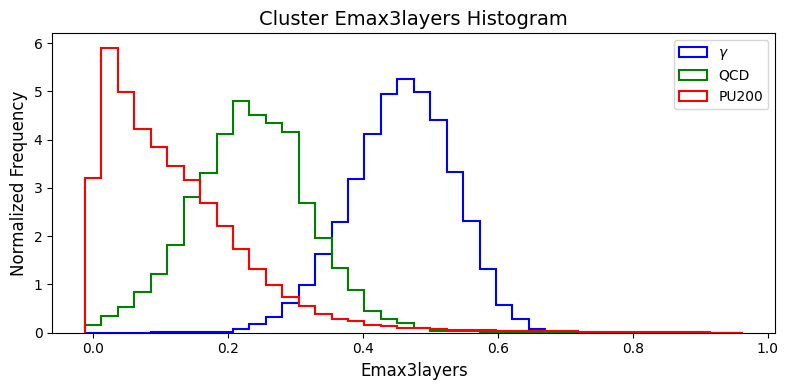

Saved: newsamples_Ref_plots/cl3d_Ref_showerlength_histogram.png


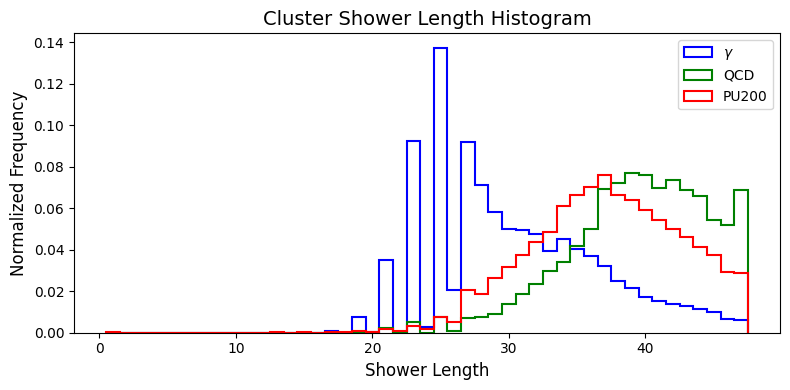

Saved: newsamples_Ref_plots/cl3d_Ref_coreshowerlength_histogram.png


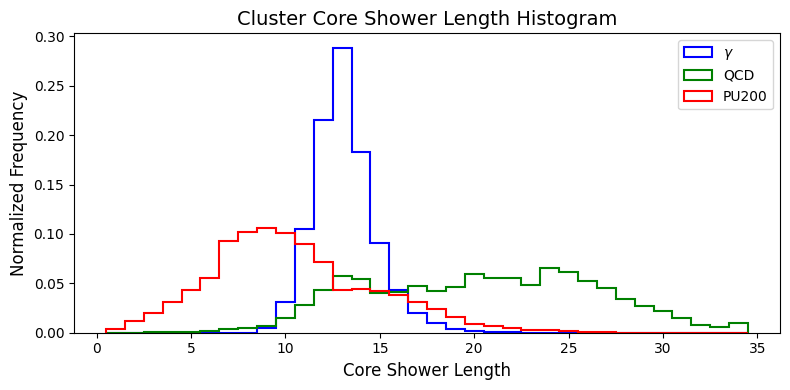

Saved: newsamples_Ref_plots/cl3d_Ref_firstlayer_histogram.png


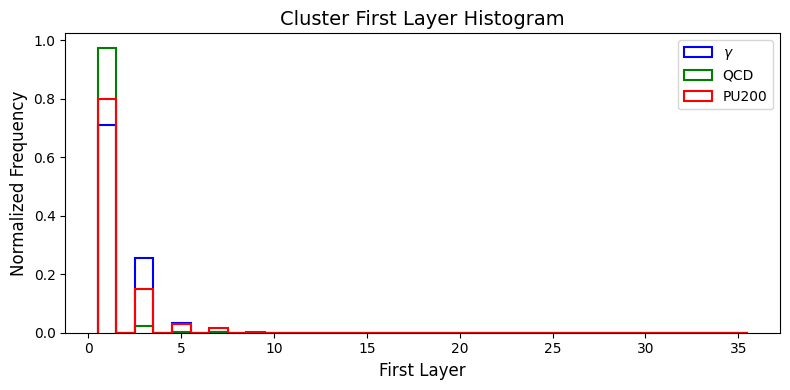

Saved: newsamples_Ref_plots/cl3d_Ref_maxlayer_histogram.png


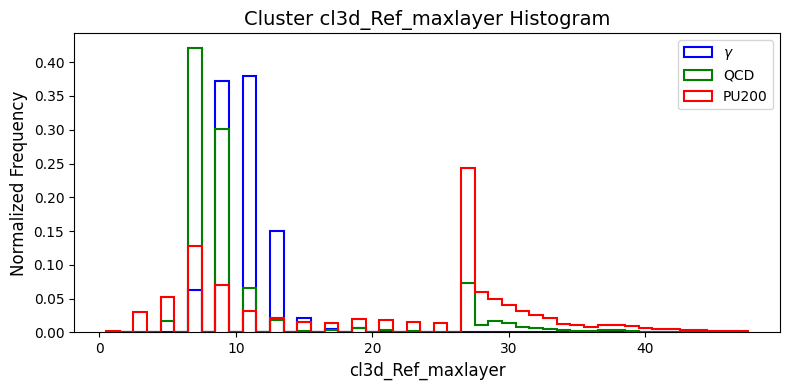

Saved: newsamples_Ref_plots/cl3d_Ref_varrr_histogram.png


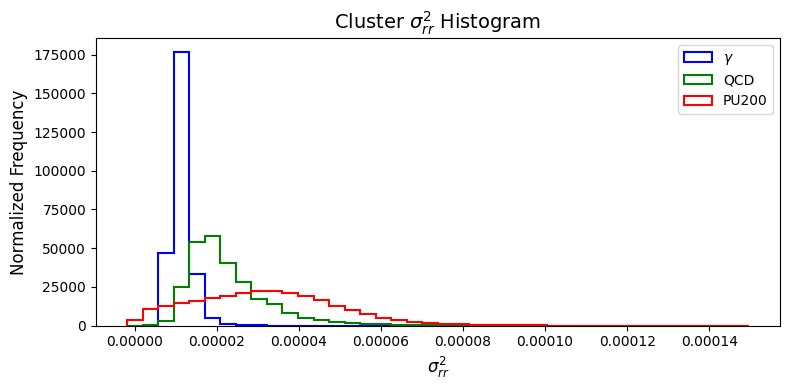

Saved: newsamples_Ref_plots/cl3d_Ref_varzz_histogram.png


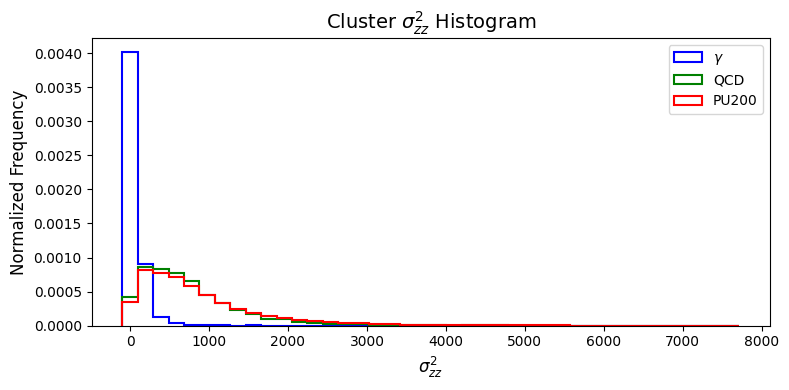

Saved: newsamples_Ref_plots/cl3d_Ref_varee_histogram.png


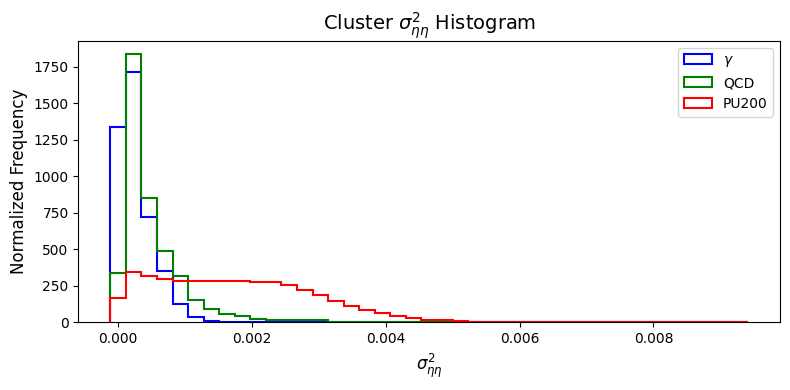

Saved: newsamples_Ref_plots/cl3d_Ref_varpp_histogram.png


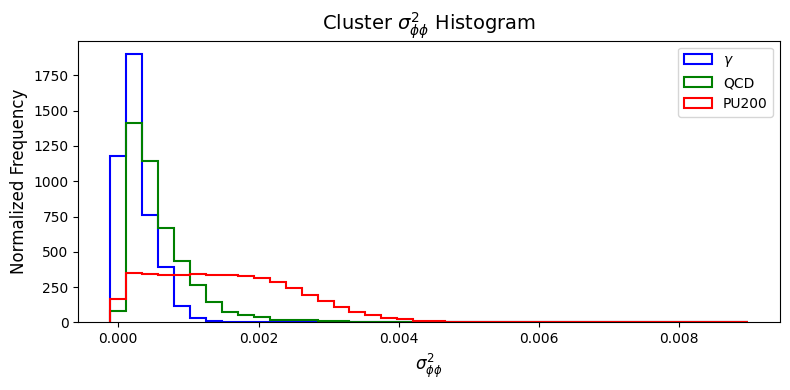

Saved: newsamples_Ref_plots/cl3d_Ref_emaxe_histogram.png


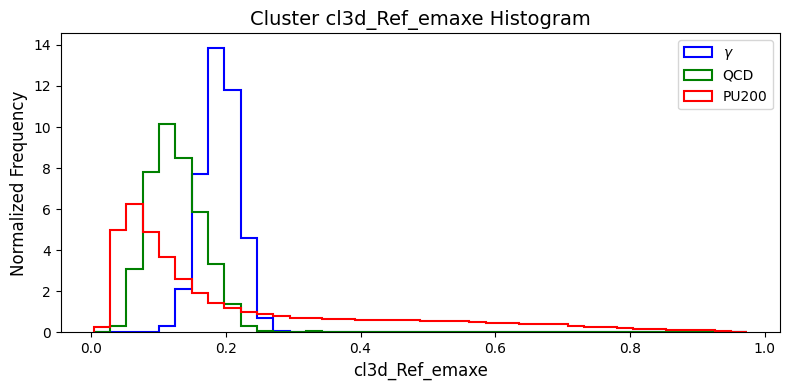

Saved: newsamples_Ref_plots/cl3d_Ref_hoe_histogram.png


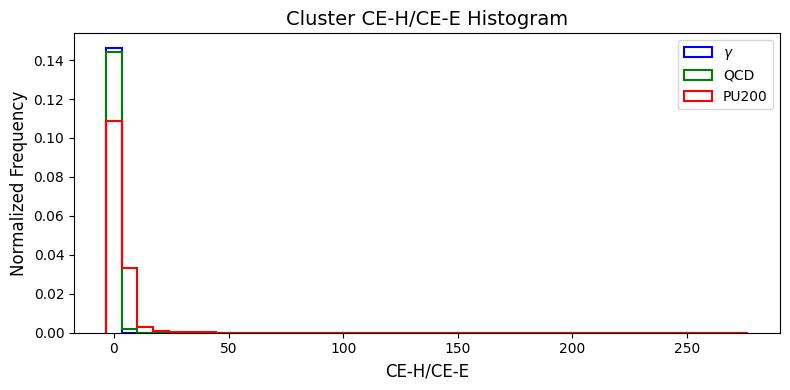

Saved: newsamples_Ref_plots/cl3d_Ref_meanz_histogram.png


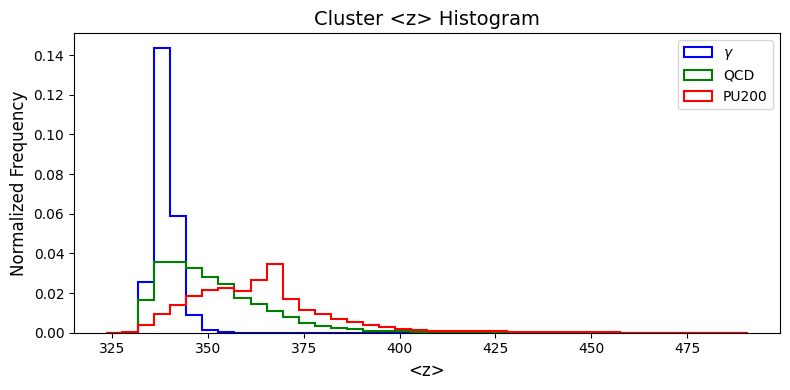

Saved: newsamples_Ref_plots/cl3d_Ref_first1layers_histogram.png


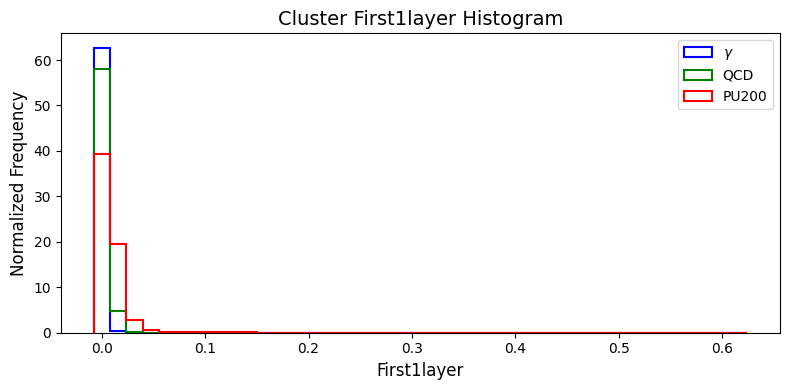

Saved: newsamples_Ref_plots/cl3d_Ref_first3layers_histogram.png


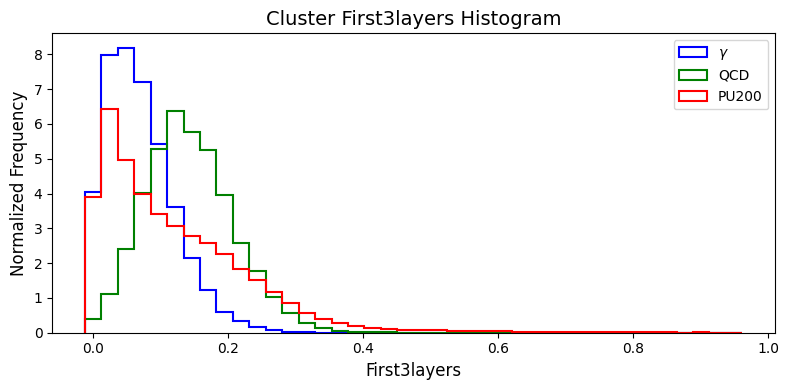

Saved: newsamples_Ref_plots/cl3d_Ref_first5layers_histogram.png


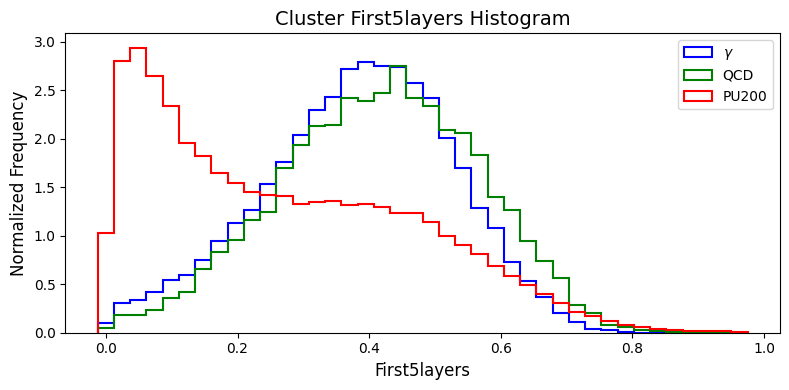

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal1layers_histogram.png


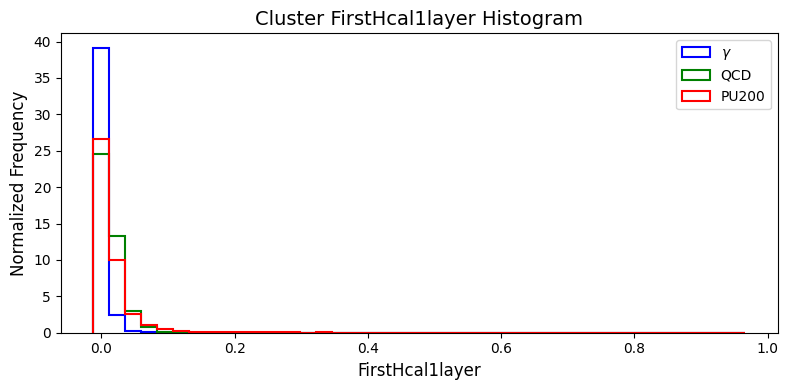

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal3layers_histogram.png


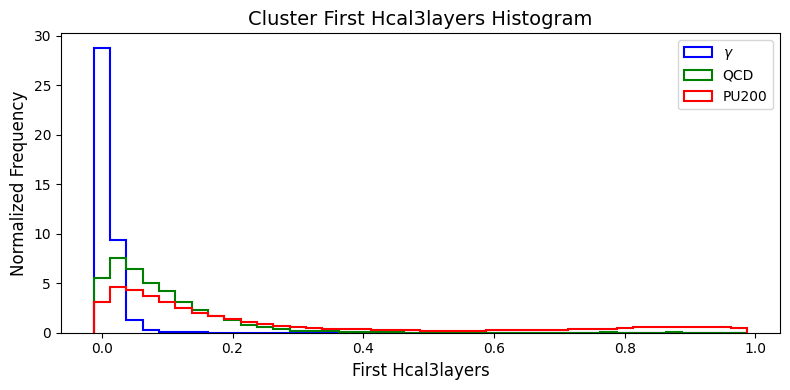

Saved: newsamples_Ref_plots/cl3d_Ref_firstHcal5layers_histogram.png


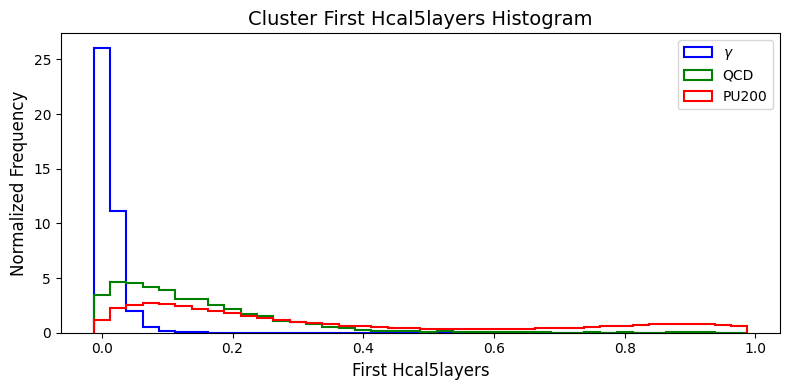

Saved: newsamples_Ref_plots/cl3d_Ref_last1layers_histogram.png


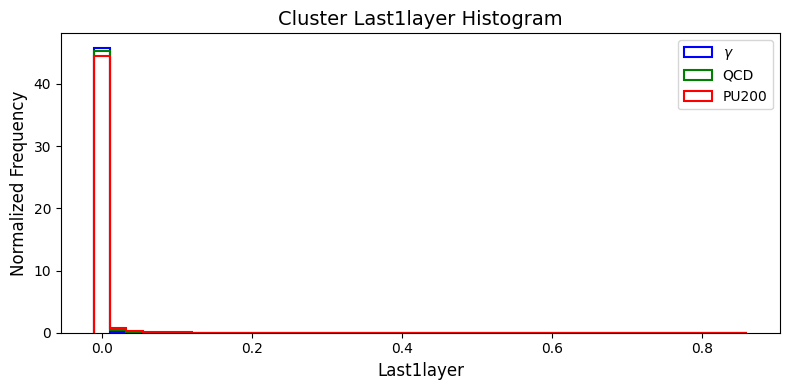

Saved: newsamples_Ref_plots/cl3d_Ref_last3layers_histogram.png


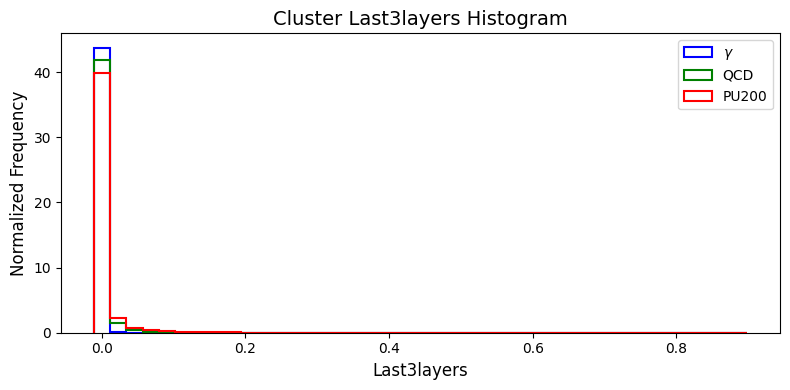

Saved: newsamples_Ref_plots/cl3d_Ref_last5layers_histogram.png


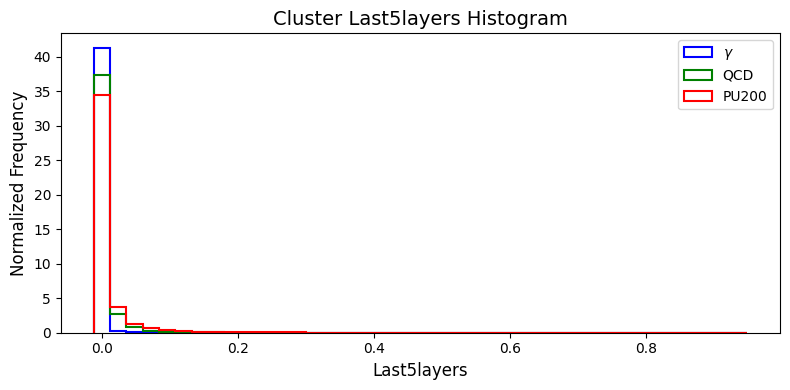

Saved: newsamples_Ref_plots/cl3d_Ref_eot_histogram.png


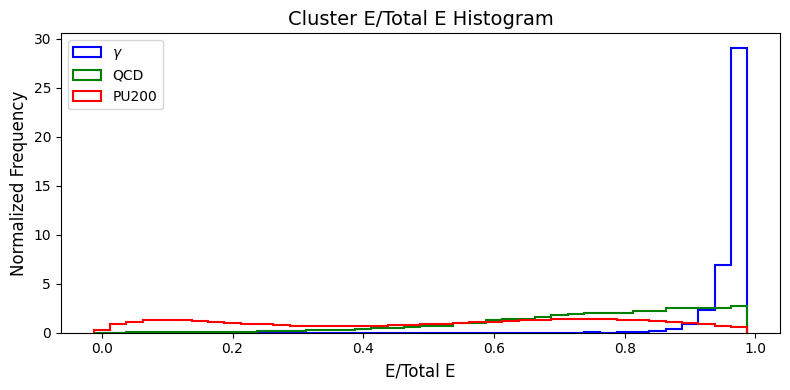

Saved: newsamples_Ref_plots/cl3d_Ref_ebm0_histogram.png


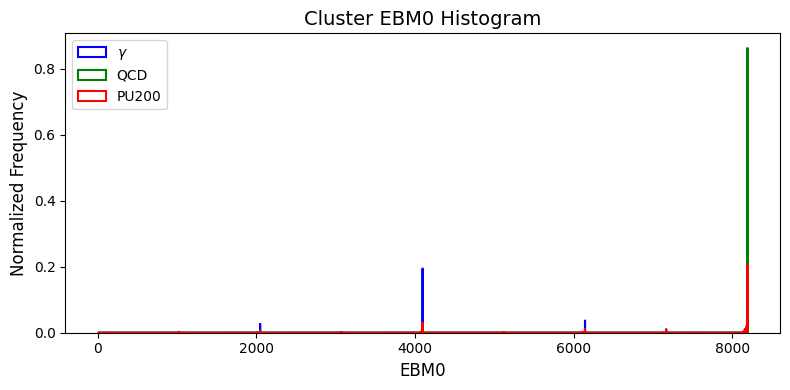

Saved: newsamples_Ref_plots/cl3d_Ref_ebm1_histogram.png


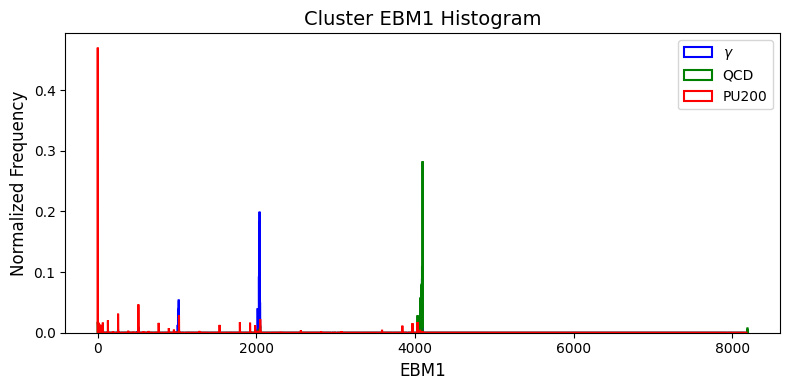

In [79]:
ana.plot_histograms(photon_df_Ref_filtered, qcd_df_Ref_filtered, PU_df_Ref, ana.variables_to_plot('Ref'), r'$\gamma$', 'QCD', 'PU200', 'newsamples_Ref_plots', ana.var_map('Ref'), 'Ref')

In [46]:
from typing import Optional, Tuple
import numpy as np
import matplotlib.pyplot as plt

def cms_header_axes(ax=None,
                    left_status="Simulation",
                    lumi_text: Optional[str] = None,
                    year_text: Optional[str] = None,
                    energy_text: str = "14 TeV",
                    pad: float = 0.01,
                    y: float = 0.98,
                    cms_size: int = 16,
                    status_size: int = 14,
                    right_size: int = 14):
    """Place 'CMS <status>' on the left and '<lumi>, <year> (<energy>)' on the right,
    aligned to the axes (not the figure). Works on Python 3.9."""
    if ax is None:
        ax = plt.gca()

    right_bits = []
    if lumi_text:
        right_bits.append(lumi_text)
    if year_text:
        right_bits.append(year_text)
    right_str = ", ".join(right_bits)
    right_str = (right_str + " (" + energy_text + ")") if right_str else energy_text

    ax.text(pad, y, r"$\bf{CMS}$  $\it{" + left_status + r"}$",
            transform=ax.transAxes, ha="left", va="top", fontsize=cms_size)
    ax.text(1 - pad, y, right_str,
            transform=ax.transAxes, ha="right", va="top", fontsize=right_size)


def plot_eta_phi_pt(df,
                    eta_col: str,
                    phi_col: str,
                    pt_col: str,
                    mode: str = "scatter",                 # "scatter" or "meanpt"
                    bins_eta: int = 60,
                    bins_phi: int = 72,
                    eta_range: Optional[Tuple[float, float]] = None,  # e.g. (1.6, 2.8)
                    phi_range: Tuple[float, float] = (-np.pi, np.pi),
                    pt_range: Optional[Tuple[float, float]] = None,   # for color scaling
                    alpha: float = 0.7,
                    s: float = 6.0,
                    add_cms_header: bool = True,
                    left_status: str = "Simulation",
                    lumi_text: Optional[str] = None,
                    year_text: Optional[str] = None,
                    energy_text: str = "14 TeV",
                    outfile: Optional[str] = None):
    """η–φ plot with pT color coding. Python 3.9-compatible annotations."""
    eta = df[eta_col].to_numpy()
    phi = df[phi_col].to_numpy()
    pt  = df[pt_col].to_numpy()
    m = np.isfinite(eta) & np.isfinite(phi) & np.isfinite(pt)

    if eta_range is not None:
        m &= (eta >= eta_range[0]) & (eta <= eta_range[1])
    if phi_range is not None:
        m &= (phi >= phi_range[0]) & (phi <= phi_range[1])

    eta, phi, pt = eta[m], phi[m], pt[m]

    fig, ax = plt.subplots(figsize=(7.0, 5.0))

    if mode.lower() == "scatter":
        sc = ax.scatter(eta, phi, c=pt, s=s, alpha=alpha,
                        vmin=(pt_range[0] if pt_range else None),
                        vmax=(pt_range[1] if pt_range else None))
        cbar = fig.colorbar(sc, ax=ax)
        cbar.set_label(r"$p_T$ [GeV]")

    elif mode.lower() == "meanpt":
        # average pT per bin
        H_sum, eta_edges, phi_edges = np.histogram2d(
            eta, phi, bins=[bins_eta, bins_phi],
            range=[eta_range if eta_range else (float(np.min(eta)), float(np.max(eta))), phi_range],
            weights=pt
        )
        H_cnt, _, _ = np.histogram2d(
            eta, phi, bins=[bins_eta, bins_phi],
            range=[eta_range if eta_range else (float(np.min(eta)), float(np.max(eta))), phi_range]
        )
        with np.errstate(invalid="ignore", divide="ignore"):
            H_mean = H_sum / H_cnt
        X, Y = np.meshgrid(eta_edges, phi_edges, indexing="ij")
        im = ax.pcolormesh(X, Y, H_mean, shading="auto",
                           vmin=(pt_range[0] if pt_range else np.nanmin(H_mean)),
                           vmax=(pt_range[1] if pt_range else np.nanmax(H_mean)))
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(r"$p_T$ [GeV]")
    else:
        raise ValueError("mode must be 'scatter' or 'meanpt'")

    ax.set_xlabel(r"$\eta$")
    ax.set_ylabel(r"$\phi$")
    ax.set_ylim(phi_range)
    if eta_range is not None:
        ax.set_xlim(eta_range)

    if add_cms_header:
        cms_header_axes(ax, left_status=left_status, lumi_text=lumi_text,
                        year_text=year_text, energy_text=energy_text, pad=0.01, y=0.98)

    fig.tight_layout()
    if outfile:
        fig.savefig(outfile, dpi=300)
    plt.show()
    plt.close(fig)


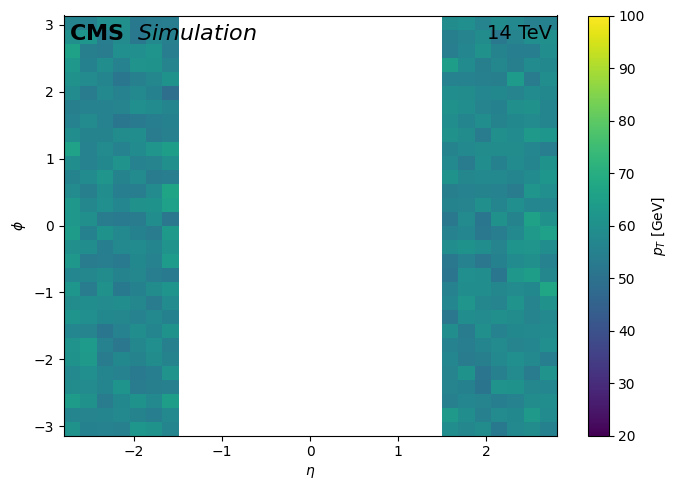

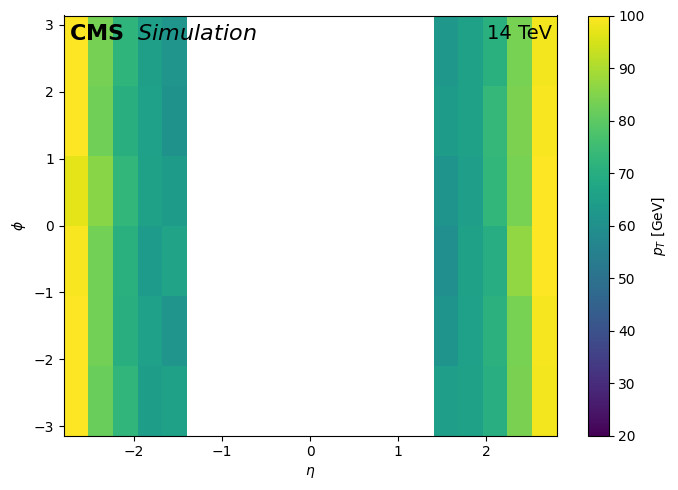

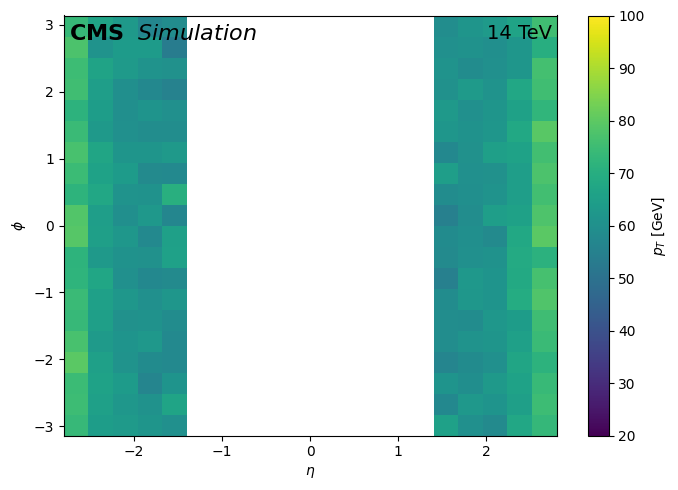

In [53]:
plot_eta_phi_pt(
    df=photon_df_p016_filtered,
    eta_col="cl3d_p016Tri_eta",
    phi_col="cl3d_p016Tri_phi",
    pt_col="cl3d_p016Tri_pt",
    mode="meanpt",
    bins_eta=30,
    bins_phi=30,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_scatter_p016.png"
)
plot_eta_phi_pt(
    df=photon_df_p045_filtered,
    eta_col="cl3d_p045Tri_eta",
    phi_col="cl3d_p045Tri_phi",
    pt_col="cl3d_p045Tri_pt",
    mode="meanpt",
    bins_eta=20,
    bins_phi=6,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_meanpt_p045_genmatched.png"
)
plot_eta_phi_pt(
    df=photon_df_p03_filtered,
    eta_col="cl3d_p03Tri_eta",
    phi_col="cl3d_p03Tri_phi",
    pt_col="cl3d_p03Tri_pt",
    mode="meanpt",
    bins_eta=20,
    bins_phi=20,
    eta_range=(-2.8, 2.8),
    phi_range=(-np.pi, np.pi),
    pt_range=(20, 100),
    left_status="Simulation",
    energy_text="14 TeV",
    outfile="eta_phi_meanpt_p03.png"
)


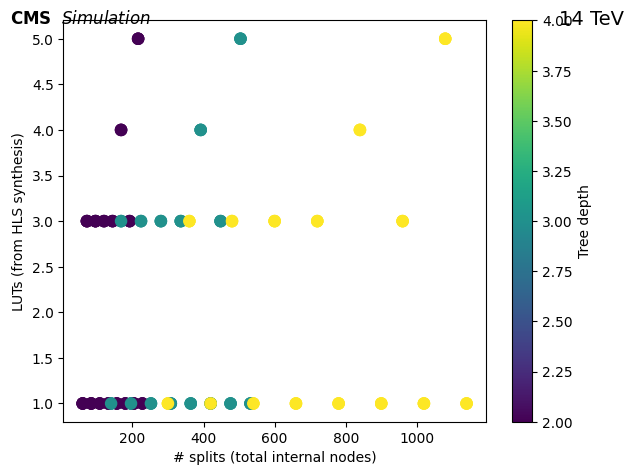

In [74]:
df = pd.read_csv("/data/data.polcms/cms/debnath/HGCAL/CMSSW_14_0_0_pre1/src/shower_shape_studies/conifer_multiclass_opti.csv")
dff = df.dropna(subset=['LUT', 'splits', 'depth']).copy()
dff['depth'] = dff['depth'].astype(int)

# Scatter: LUTs vs splits, color = depth
plt.figure()
sc = plt.scatter(dff['splits'], dff['LUT'], c=dff['depth'], s=64)
plt.xlabel('# splits (total internal nodes)')
plt.ylabel('LUTs (from HLS synthesis)')
cbar = plt.colorbar(sc)
cbar.set_label('Tree depth')
fig = plt.gcf()
fig.text(0.02, 0.98, r"$\bf{CMS}$  $\it{Simulation}$", ha="left", va="top", fontsize=12)
fig.text(0.98, 0.98, "14 TeV",                 ha="right", va="top", fontsize=14)
fig.subplots_adjust(top=2)
plt.tight_layout()
plt.show()